# Analyzing Multiple Stations with SensorManager

This notebook demonstrates how to:
- Load data using `DataLoader` and configuration from `ConfigurationManager`.
- Initialize a `SensorManager` to manage multiple stations and their sensors.
- Retrieve temperature data from each station, compute basic statistics, and plot the station locations on a map.

**Key Steps:**
1. Load NetCDF data and config.
2. Initialize `SensorManager`.
3. Print temperature statistics (mean, max, min, std) for each station.
4. Plot station locations along with data extents on a map.




Loading and combining Temperature files...
Loading temperature data from: ../data/NetCDF/April-30-temp.nc
Loading temperature data from: ../data/NetCDF/May-01-temp.nc
Loading temperature data from: ../data/NetCDF/May-02-temp.nc
Loading temperature data from: ../data/NetCDF/May-03-temp.nc

Loading and combining U_wind files...
Loading u_wind data from: ../data/NetCDF/April-30-u-wind.nc
Loading u_wind data from: ../data/NetCDF/May-01-u-wind.nc
Loading u_wind data from: ../data/NetCDF/May-02-u-wind.nc
Loading u_wind data from: ../data/NetCDF/May-03-u-wind.nc

Loading and combining V_wind files...
Loading v_wind data from: ../data/NetCDF/April-30-v-wind.nc
Loading v_wind data from: ../data/NetCDF/May-01-v-wind.nc
Loading v_wind data from: ../data/NetCDF/May-02-v-wind.nc
Loading v_wind data from: ../data/NetCDF/May-03-v-wind.nc
Available Stations (lat, lon): [(np.float64(56.05), np.float64(-112.05)), (np.float64(57.05), np.float64(-111.05000000000005)), (np.float64(56.949999999999996), np.

,Latitude,Longitude,Mean Temp (K),Max Temp (K),Min Temp (K),Std Temp,Count
0,56.05,-112.05,288.317688,300.497070,277.442444,6.132779,96.0
1,57.05,-111.05,288.459930,302.001160,277.122192,6.163898,96.0
2,56.95,-111.25,288.927643,302.635254,277.898804,6.251727,96.0
3,56.55,-111.15,289.070587,302.698303,278.500061,6.246727,96.0
4,56.15,-110.95,288.276489,301.226990,277.940857,6.265741,96.0
5,57.25,-111.65,288.952972,302.575623,276.945618,6.483683,96.0


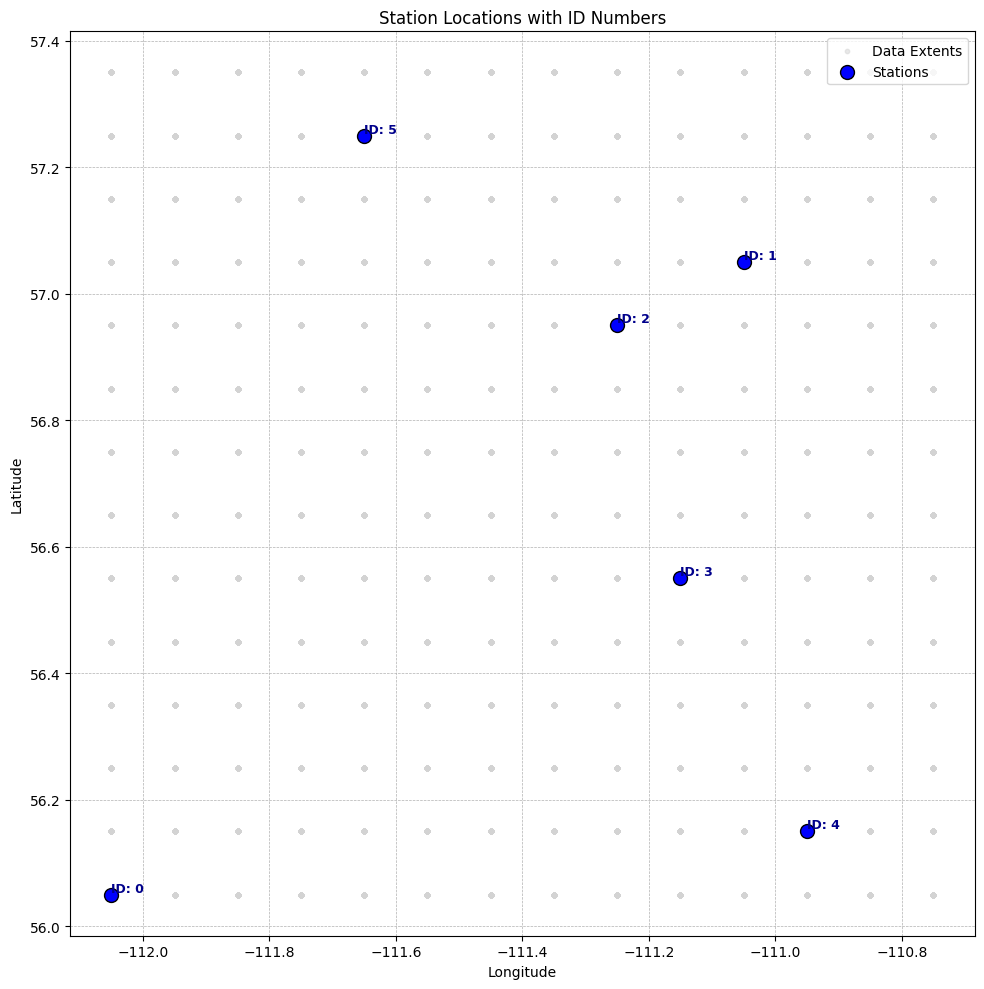

In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we can import from src
sys.path.append("..")

from src.data_handling.data_loader import DataLoader
from src.utils.configuration_manager import ConfigurationManager
from src.sensors.sensor_manager import SensorManager

# Step 1: Load Data
data_dir = "../data/NetCDF"
file_groups = {
    "temperature": ["April-30-temp.nc", "May-01-temp.nc", "May-02-temp.nc", "May-03-temp.nc"],
    "u_wind": ["April-30-u-wind.nc", "May-01-u-wind.nc", "May-02-u-wind.nc", "May-03-u-wind.nc"],
    "v_wind": ["April-30-v-wind.nc", "May-01-v-wind.nc", "May-02-v-wind.nc", "May-03-v-wind.nc"]
}

loader = DataLoader(data_dir=data_dir)
data_dict = loader.load_all(file_groups)

# Step 2: Load Configuration
config_manager = ConfigurationManager(config_path="../config/default_config.yaml")

# Step 3: Initialize SensorManager
sensor_manager = SensorManager(data_dict=data_dict, config_manager=config_manager)
all_stations = sensor_manager.get_all_stations()

print("Available Stations (lat, lon):", list(all_stations.keys()))

# Step 4: Retrieve Temperature Data and Compute Statistics
summary_rows = []
for (lat, lon), station in all_stations.items():
    temp_sensor = station.get_sensor("temperature")
    if temp_sensor:
        stats = temp_sensor.calculate_statistics()
        mean_val = stats["mean"]
        max_val = stats["max"]
        min_val = stats["min"]
        std_val = stats["std"]
        count_val = stats["count"]
        
        summary_rows.append({
            "Latitude": lat,
            "Longitude": lon,
            "Mean Temp (K)": mean_val,
            "Max Temp (K)": max_val,
            "Min Temp (K)": min_val,
            "Std Temp": std_val,
            "Count": count_val
        })
    else:
        summary_rows.append({
            "Latitude": lat,
            "Longitude": lon,
            "Mean Temp (K)": None,
            "Max Temp (K)": None,
            "Min Temp (K)": None,
            "Std Temp": None,
            "Count": 0
        })

summary_report = pd.DataFrame(summary_rows)
print("\nStation Temperature Summary:")
display(summary_report)

# Step 5: Plot the Stations and Data Extents
# Extract data extents from the temperature_df (assuming temperature is representative)
# Plot the Stations and Data Extents with Station ID instead of Mean Temperature
temperature_df = data_dict["temperature"]

plt.figure(figsize=(10, 10))

# Plot the data extents
plt.scatter(temperature_df["longitude"], temperature_df["latitude"],
            color="lightgrey", alpha=0.5, s=10, label="Data Extents")

# Plot station locations
plt.scatter(summary_report["Longitude"], summary_report["Latitude"],
            c="blue", s=100, edgecolor="black", label="Stations")

# Annotate stations with ID number
for idx, row in summary_report.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    station_id = idx  # Using the DataFrame index as the ID number
    plt.text(lon, lat, f"ID: {station_id}", fontsize=9,
             ha="left", va="bottom", color="darkblue", fontweight="bold")

# Ensure equal aspect ratio for lat/lon
plt.gca().set_aspect('equal', adjustable='box')

plt.title("Station Locations with ID Numbers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
